<a href="https://colab.research.google.com/github/WinetraubLab/coregister-xz/blob/main/coregister_xz.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
  
<a href="https://github.com/WinetraubLab/coregister-xz/blob/main/coregister_xz.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

# Overview
This notebook will compute the best plane fit based on photobleach lines.


In [1]:
# @title Optical Setup Inputs (Shouldn't Change)

# Line Positions
v_line_bias_mm = 500e-3
h_line_bias_mm = -650e-3
base_mm = 90e-3
v_lines_spacing = [-1, 0, 1] # Unitless, units will be added later in the code
h_lines_spacing = [-3, 0, 1, 3] # Unitless, units will be added later in the code

In [2]:
# @title Inputs (Cutting)

cut_position = "2" #@param [1,2,3,4]
cut_position = int(cut_position)
mirror = "False" #@param ["True","False"]
mirror = mirror == "True"

In [3]:
# @title Inputs (Fluorescence Image Points)

# On the fluorescence image, record which points are on every line (pixels)
# Lines show up from left to right on the flourescence image
fluorescence_image_points_on_line_pix = [
  [ [ 143, 0], [ 143, 1] ], # A few points on line 0 (left most line in image)
  [ [ 272, 0], [ 272, 1] ], # A few points on line 1 (next line from left)
  [ [ 412, 0], [ 412, 1] ], # ...
  [ [1359, 0], [1359, 1] ],
  [ [1492, 0], [1492, 1] ],
  [ [1625, 0], [1625, 1] ],
  [ [1894, 0], [1894, 1] ], # A few points on line 6 (right most line image)
  ]

if (len(fluorescence_image_points_on_line_pix) !=
    len(v_lines_spacing) + len(h_lines_spacing)):
    raise ValueError('Number of lines identified in the fluorescence_image should be equal to number of lines in template')

In [4]:
# @title Environment Setup

if not 'setup_env_coregister_xz' in globals():
  setup_env_coregister_xz = True
  !git clone --recurse-submodules https://github.com/WinetraubLab/coregister-xz/
  %cd ./coregister-xz/

from plane.fit_plane import FitPlane
from plane.plot_fit_plane import plot_fit_plane
import numpy as np
import matplotlib.pyplot as plt

Cloning into 'coregister-xz'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 192 (delta 94), reused 127 (delta 42), pack-reused 0
Receiving objects: 100% (192/192), 125.43 KiB | 1.65 MiB/s, done.
Resolving deltas: 100% (94/94), done.
/content/coregister-xz


FitPlane.from_fitting_points_on_photobleach_lines([[[143, 0], [143, 1]], [[272, 0], [272, 1]], [[412, 0], [412, 1]], [[1359, 0], [1359, 1]], [[1492, 0], [1492, 1]], [[1625, 0], [1625, 1]], [[1894, 0], [1894, 1]]],[-0.92, -0.65, -0.56, -0.38, 0.41000000000000003, 0.5, 0.59],["h", "h", "h", "h", "v", "v", "v"])


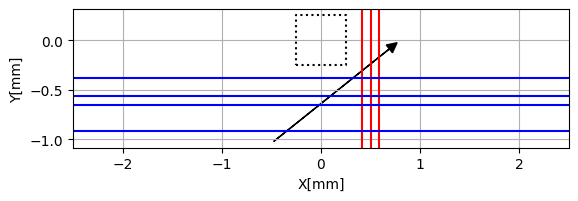

Fit Statistics:
---------------
Pixel Size: |u| = 0.552um, |v| = 0.552um
Signed Distance from Origin: 0.500mm
X-Y Rotation: 38.66 degrees
Tilt: 0.00 degrees

Data to Keep:
---------------
fp = FitPlane.from_json('{"u": [0.00043130647635246394, 0.000345058811076715, -3.717163927313716e-09], "v": [1.4710455076283324e-15, -2.837357085394565e-16, 0.0005521104361224241], "h": [-0.22042558433406678, -0.8160746402534239, 0.0], "recommended_center_pix": [1234.5985311184763, 0.5]}')
photobleach_line_position_mm = np.array([-0.92, -0.65, -0.56, -0.38, 0.41000000000000003, 0.5, 0.59])
photobleach_line_group = np.array(['h', 'h', 'h', 'h', 'v', 'v', 'v'])


In [5]:
# @title Do the work

# Create the base unit structure
v_photobleach_line_position_mm = np.array(v_lines_spacing) * base_mm + v_line_bias_mm
h_photobleach_line_position_mm = np.array(h_lines_spacing) * base_mm + h_line_bias_mm

# Combine v lines and h lines according to order
def combine(v_photobleach_line_position_mm, h_photobleach_line_position_mm,
            order='vh',flip_v=False, flip_h=False):
  if flip_v:
    v = np.flipud(v_photobleach_line_position_mm)
  else:
    v = v_photobleach_line_position_mm

  if flip_h:
    h = np.flipud(h_photobleach_line_position_mm)
  else:
    h = h_photobleach_line_position_mm

  if order == 'hv':
    photobleach_line_position_mm = np.concatenate((h, v), axis=0)
    photobleach_line_group = (['h'] * len(h)) + (['v'] * len(v))
  else:
    photobleach_line_position_mm = np.concatenate((v, h), axis=0)
    photobleach_line_group = (['v'] * len(v)) + (['h'] * len(h))

  return photobleach_line_position_mm, photobleach_line_group

if cut_position == 1:
  photobleach_line_position_mm, photobleach_line_group = combine(
      v_photobleach_line_position_mm, h_photobleach_line_position_mm,
      order='vh',flip_v=False, flip_h=True)
elif cut_position == 2:
  photobleach_line_position_mm, photobleach_line_group = combine(
      v_photobleach_line_position_mm, h_photobleach_line_position_mm,
      order='hv',flip_v=False, flip_h=False)
elif cut_position == 3:
  photobleach_line_position_mm, photobleach_line_group = combine(
      v_photobleach_line_position_mm, h_photobleach_line_position_mm,
      order='hv',flip_v=True, flip_h=False)
elif cut_position == 4:
  photobleach_line_position_mm, photobleach_line_group = combine(
      v_photobleach_line_position_mm, h_photobleach_line_position_mm,
      order='vh',flip_v=False, flip_h=False)

# Flip lines based on mirror status
fluorescence_image_points_on_line_pix = np.array(fluorescence_image_points_on_line_pix)
if mirror:
  fluorescence_image_points_on_line_pix = np.flipud(fluorescence_image_points_on_line_pix)

# Fit & Plot
fp = FitPlane.from_fitting_points_on_photobleach_lines(
      fluorescence_image_points_on_line_pix,
      photobleach_line_position_mm,
      photobleach_line_group,
      print_inputs = True, # Comment out if printing inputs is not important
    )
plot_fit_plane(fp,
  v_photobleach_line_position_mm,
  h_photobleach_line_position_mm, reverse_plot=mirror)

if mirror:
  raise ValueError('Using mirror=True will make reslicing significantly more difficult. Please flip/mirror the fluorescence image instead using ImageJ')

# Print stats
print('Fit Statistics:')
print('---------------')
print("Pixel Size: |u| = %.3fum, |v| = %.3fum" %
  (fp.u_norm_mm()*1e3, fp.v_norm_mm()*1e3 ) )
print("Signed Distance from Origin: %.3fmm" % fp.distance_from_origin_mm())
print("X-Y Rotation: %.2f degrees" % fp.xy_rotation_deg())
print("Tilt: %.2f degrees" % fp.tilt_deg())

# Serialize to JSON
print("")
print('Data to Keep:')
print('---------------')
print("fp = FitPlane.from_json('" + fp.to_json() + "')")
array_str = ', '.join(map(str, photobleach_line_position_mm))
print(f'photobleach_line_position_mm = np.array([{array_str}])')
print(f'photobleach_line_group = np.array({photobleach_line_group})')

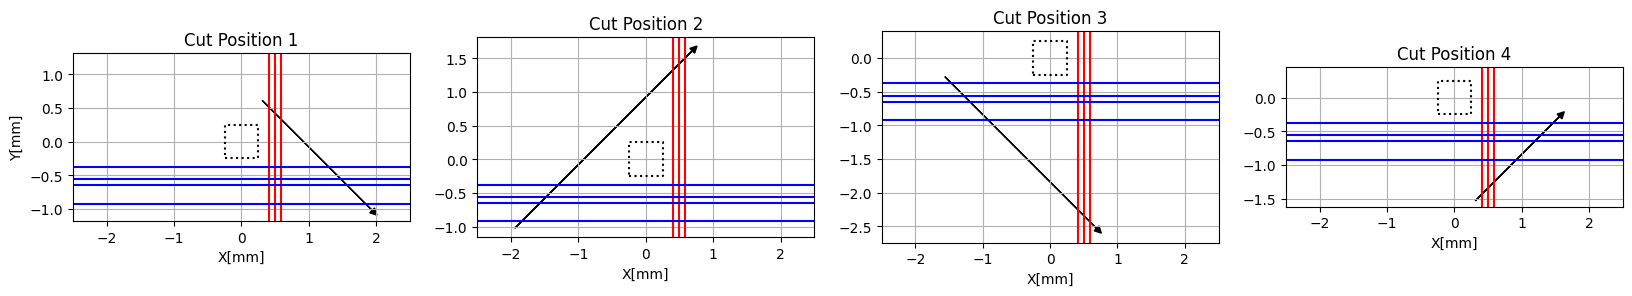

In [6]:
# @title Show Cut Positions For Future Reference

# Define planes
pos = np.max([np.max(np.abs(v_photobleach_line_position_mm)), np.max(np.abs(h_photobleach_line_position_mm))])
fp1 = FitPlane(u=[1,-1,0],v=[0,0,1.41],h=[+1*pos, 0, 0])
fp2 = FitPlane(u=[1,+1,0],v=[0,0,1.41],h=[-1*pos, 0, 0])
fp3 = FitPlane(u=[1,-1,0],v=[0,0,1.41],h=[-2*pos, 0, 0])
fp4 = FitPlane(u=[1,+1,0],v=[0,0,1.41],h=[+2*pos, 0, 0])

# Plot them
fig, axs = plt.subplots(1,4, figsize=(20, 5))
plot_fit_plane(fp1, v_photobleach_line_position_mm, h_photobleach_line_position_mm, ax=axs[0], reverse_plot=mirror)
plot_fit_plane(fp2, v_photobleach_line_position_mm, h_photobleach_line_position_mm, ax=axs[1], reverse_plot=mirror)
plot_fit_plane(fp3, v_photobleach_line_position_mm, h_photobleach_line_position_mm, ax=axs[2], reverse_plot=mirror)
plot_fit_plane(fp4, v_photobleach_line_position_mm, h_photobleach_line_position_mm, ax=axs[3], reverse_plot=mirror)
axs[0].set_title('Cut Position 1')
axs[1].set_title('Cut Position 2')
axs[2].set_title('Cut Position 3')
axs[3].set_title('Cut Position 4')
for ax in axs[1:4]:
    ax.set_ylabel('')
plt.show()